# Plots for Hicks et al. 2019 - reported only

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os
import geopandas as gp
from mpl_toolkits.basemap import Basemap
import shapely
import shapefile as shp
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

import pdb

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Abline for plotting
def abline(intercept, slope, ax=None):
    """Plot a line from slope and intercept"""
    if ax==None:
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')
    else:
        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, '--')


# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

def dcize(x):
    return (x-min(x))/max(x-min(x))

def dcizeq(x,qi=75):
    uq = np.percentile(x,qi)
    x_ = x
    x_[x_>uq] = uq
    qlabels = np.round(np.percentile(x,(qi*.01,qi*.25,qi*.50,qi*.75,qi)))
    return qlabels, (x_-min(x_))/max(x_-min(x_))


def dcmax(x_,maxval):
    qi = maxval/max(x)
    x_[x_>maxval] = maxval
    qlabels = np.round(np.percentile(x_,(qi*.01,qi*.25,qi*.50,qi*.75,qi)))
    return qlabels, (x_-min(x_))/max(x_-min(x_))

def qmax(x,qi=75):
    uq = np.percentile(x,qi)
    x_ = x
    x_[x_>uq] = uq
    return x_

def qbins(x,nbins=4):
    data_percentile = x/max(x)  
    bin_edges = np.percentile(x,[(100/nbins)*r for r in range(nbins+1)])
    bins_percentile = bin_edges/max(x)
    data_binned_indices = np.digitize(data_percentile, bins_percentile, right=True)
    return np.round(np.sort(np.unique(bin_edges))), data_binned_indices

## Import data sources

In [2]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_csv('Traits_data.csv')
# Reported species-level catch per country
sdata = pd.read_csv('Reported_EEZ.csv')


In [3]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

In [4]:
# Add traits information to sau dataframe
indx = match(sdata.species.unique(),list(tdata.species_traits_all.values))
rindx = match(sdata.species,list(sdata.species.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    sdata[trait] = tdata[trait].values[indx][rindx]

In [5]:
# Nutrient names
Nutrients = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin A', 'n-3 fatty acids', 'Protein']
Nkeys = ['Ca_Value', 'Fe_Value', 'Se_Value', 'Zn_Value', 'VitA_Value', 'O3_Value', 'Protein_Value_perc']
nnutrients = len(Nutrients)

## Import results

In [6]:
# Model estimates
Protein = pd.read_csv('Protein_results.csv')
Zinc = pd.read_csv('Zinc_results.csv')
Iron = pd.read_csv('Iron_results.csv')
Calcium = pd.read_csv('Calcium_results.csv')
Omega3 = pd.read_csv('Omega-3_results.csv')
Vitamin_A = pd.read_csv('Vitamin_A_results.csv')
Selenium = pd.read_csv('Selenium_results.csv')

Results = [Calcium, Iron, Selenium, Zinc, Vitamin_A,  Omega3, Protein]


In [7]:
# Standardized estiamtes
Protein_std = pd.read_csv('Protein_std_results.csv')
Zinc_std = pd.read_csv('Zinc_std_results.csv')
Iron_std = pd.read_csv('Iron_std_results.csv')
Calcium_std = pd.read_csv('Calcium_std_results.csv')
Omega3_std = pd.read_csv('Omega3_std_results.csv')
Vitamin_A_std = pd.read_csv('Vitamin_A_std_results.csv')
Selenium_std = pd.read_csv('Selenium_std_results.csv')

Results_std = [Calcium_std, Iron_std, Selenium_std, Zinc_std,  Vitamin_A_std, Omega3_std,  Protein_std]

In [8]:
# Variable order
varord = ['pelagic', 'demersal',  'TL', 'MaxDepth', 'tropical', 'temperate','polar_deep', 'LMax', 'tm', 'K', 'flat', 'elongate', 'short_deep','fusiform'][::-1]

# Variable names
varnames = ['Pelagic pathway', 'Demersal pathway', 'Trophic level', 'Max depth', 'Tropical', 'Temperate', 'Cold', 'Max length', 'Maturity age', 'Growth rate', 'Flat', 'Elongate', 'Short-deep','Fusiform'][::-1]
nvar = len(varnames)

# Figure 1

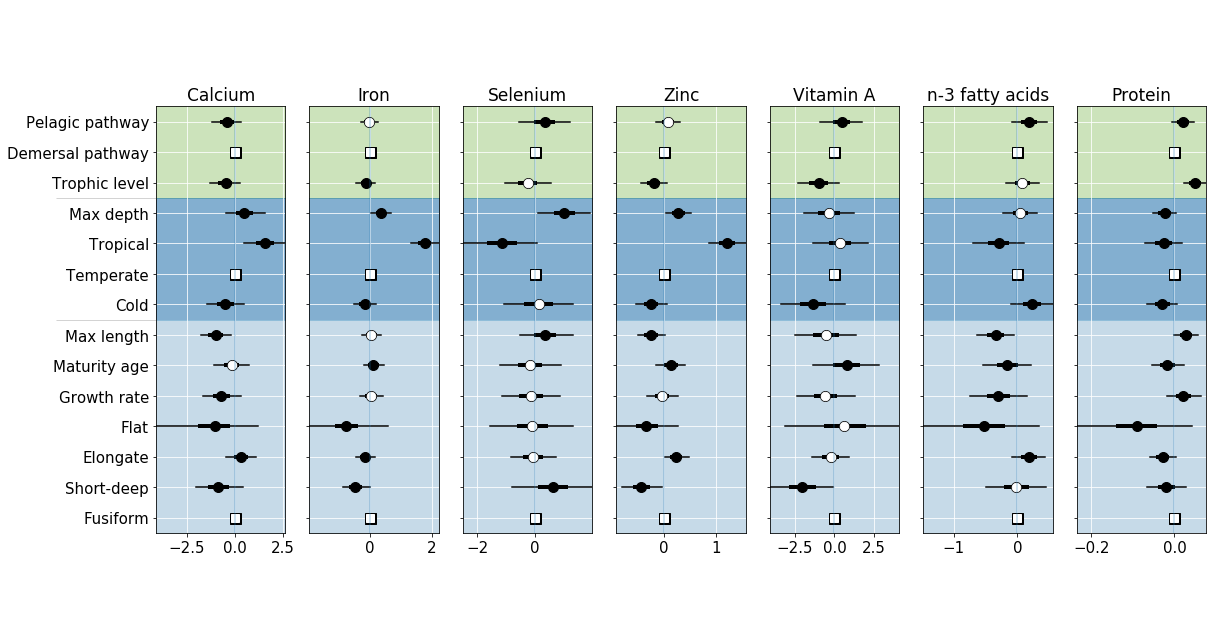

In [9]:
# Set up multipanel grid
fig = plt.figure(figsize=(17, 9),facecolor='white')
gs = mp.gridspec.GridSpec(1, 7)
ax = [fig.add_subplot(gs[0,i]) for i in range(7)]

# Asthetic controls
split1,split2,split3 = 6.5, 10.5, nvar+.5
jit = 0.1
szero = (25,75)
ymajor_ticks = np.arange(0, nvar)
yminor_ticks = (split1,split2)
xmajor_ticks = np.arange(-3, 3)
xminor_ticks = np.arange(-3, 3, 0.1)

# Loop over nutrietns
for i in range(nnutrients):
    ax_ = ax[i]
    # Plot standardized results
    resx = Results_std[i]
    rescol = list(resx.columns)
    xlimx = []
    # Loop over variables
    for j in range(nvar):
        yloc = j
        try:
            trace = resx[resx.columns[rescol.index(varord[j])]]
            mx = '.'
        except ValueError:
            pass
        else:
            if np.mean(trace)==0:
                mx = 's'
                ms = 8
            else:
                mx = '.'
                ms = 17
            x95 = np.percentile(trace,(2.5,97.5))
            xlimx += list(x95)
            ax_.plot(x95,(j,j),c='black')
            ax_.plot(np.percentile(trace,(25,75)),(j,j),c='black',linewidth=4)
            ax_.plot(np.median(trace),j, marker=mx, markersize=ms+3,c='black')
            if spanzero(np.percentile(trace,szero)):
                ax_.plot(np.median(trace), j, marker=mx, markersize=ms,c='white')
    ax_.set_title(Nutrients[i],fontsize=17)
    #ax_.set_xlim(-2,2)
    ax_.tick_params(axis='both', which='major', labelsize=15)
    ax_.set_facecolor('#E8E8EE')
    ax_.set_yticks(ymajor_ticks) 
    #ax_.set_xticks(xmajor_ticks)
    #ax_.set_xticks(xminor_ticks, minor=True)
    #ax_.grid(which='minor', alpha=0.2)
    ax_.grid(color='white')
    ax_.axvline(x=0, linestyle="-",alpha=0.3)
    ax_.fill_betweenx((split2, split3), -5, 5, color='#b2df8a', alpha=.5)
    ax_.fill_betweenx((split1, split2), -5, 5, color='#1f78b4', alpha=.5)
    ax_.fill_betweenx((-0.5, split1), -5, 5, color='#a6cee3', alpha=.5)
    ax_.set_xlim(min(xlimx),max(xlimx))
    ax_.set_ylim(-0.5,split3-1)
    if i==0:
        ax_.set_yticklabels(varnames)
        ax_.set_yticks(yminor_ticks, minor=True)
        ax_.tick_params('y', length=100, width=1, which='minor',color='lightgrey')
    else:
        ax_.set_yticklabels('')

plt.tight_layout()
plt.savefig('Figure_1_reported.svg')


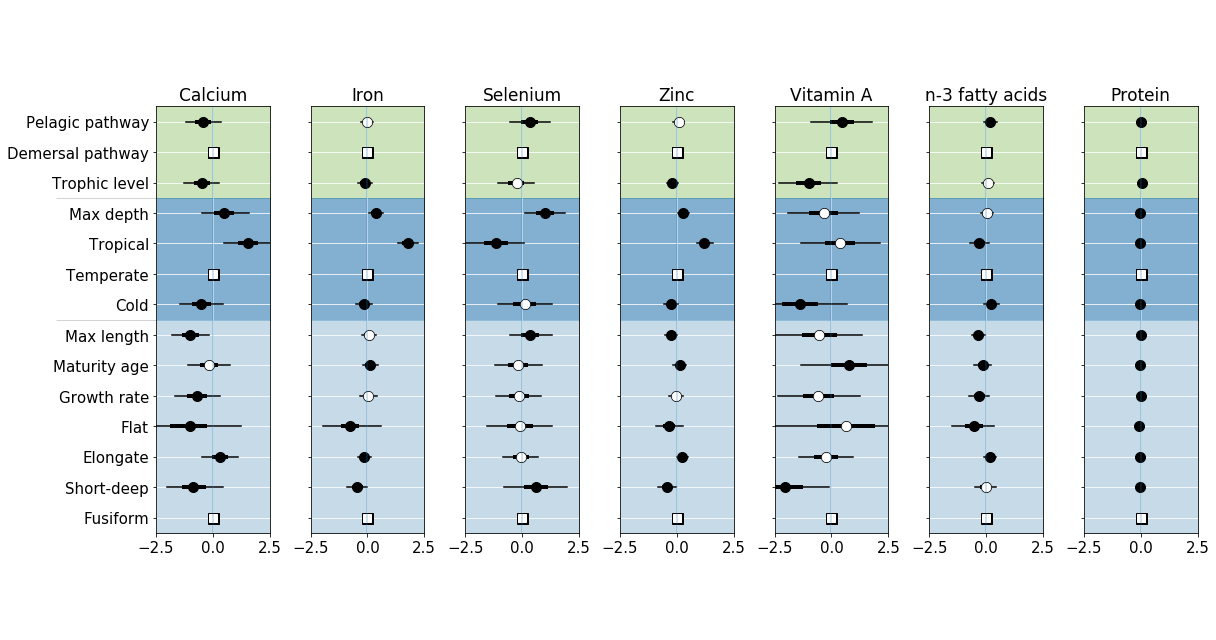

In [10]:
# Set up multipanel grid
fig = plt.figure(figsize=(17, 9),facecolor='white')
gs = mp.gridspec.GridSpec(1, 7)
ax = [fig.add_subplot(gs[0,i]) for i in range(7)]

# Asthetic controls
split1,split2,split3 = 6.5, 10.5, nvar+.5
jit = 0.1
ymajor_ticks = np.arange(0, nvar)
yminor_ticks = (split1,split2)
xmajor_ticks = np.arange(-3, 3)
xminor_ticks = np.arange(-3, 3, 0.1)

# Loop over nutrietns
for i in range(nnutrients):
    ax_ = ax[i]
    # Plot standardized results
    resx = Results_std[i]
    rescol = list(resx.columns)
    xlimx = []
    # Loop over variables
    for j in range(nvar):
        yloc = j
        try:
            trace = resx[resx.columns[rescol.index(varord[j])]]
            mx = '.'
        except ValueError:
            pass
        else:
            if np.mean(trace)==0:
                mx = 's'
                ms = 8
            else:
                mx = '.'
                ms = 17
            x95 = np.percentile(trace,(2.5,97.5))
            xlimx += list(x95)
            ax_.plot(x95,(j,j),c='black')
            ax_.plot(np.percentile(trace,(25,75)),(j,j),c='black',linewidth=4)
            ax_.plot(np.median(trace),j, marker=mx, markersize=ms+3,c='black')
            if spanzero(np.percentile(trace,szero)):
                ax_.plot(np.median(trace), j, marker=mx, markersize=ms,c='white')
    ax_.set_title(Nutrients[i],fontsize=17)
    ax_.set_xlim(-2.5,2.5)
    ax_.tick_params(axis='both', which='major', labelsize=15)
    ax_.set_facecolor('#E8E8EE')
    ax_.set_yticks(ymajor_ticks) 
    #ax_.set_xticks(xmajor_ticks)
    #ax_.set_xticks(xminor_ticks, minor=True)
    #ax_.grid(which='minor', alpha=0.2)
    ax_.grid(color='white')
    ax_.axvline(x=0, linestyle="-",alpha=0.3)
    ax_.fill_betweenx((split2, split3), -5, 5, color='#b2df8a', alpha=.5)
    ax_.fill_betweenx((split1, split2), -5, 5, color='#1f78b4', alpha=.5)
    ax_.fill_betweenx((-0.5, split1), -5, 5, color='#a6cee3', alpha=.5)
    #ax_.set_xlim(min(xlimx),max(xlimx))
    ax_.set_ylim(-0.5,split3-1)
    if i==0:
        ax_.set_yticklabels(varnames)
        ax_.set_yticks(yminor_ticks, minor=True)
        ax_.tick_params('y', length=100, width=1, which='minor',color='lightgrey')
    else:
        ax_.set_yticklabels('')

plt.tight_layout()
plt.savefig('Figure_ED1_reported.svg')


# Figure S1

In [11]:
# Variable order
Svarord = ['whole','whole_parts','muscle', 'dry','wet', 'Expert', 'FAO','WOS', 'reef_associated', 'benthopelagic', 'pelagic_neritic', 'pelagic_oceanic', 'DemersPelag'][::-1]

# Variable names
Svarnames = ['Whole','Whole-noparts','Muscle' 'Dry', 'Wet', 'Expert', 'FAO','WoS','Reef','Benthopelagic', 'Pelagic/neritic', 'Pelagic/oceanic','Demersal/pelagic'][::-1]

Snvar = len(Svarnames)

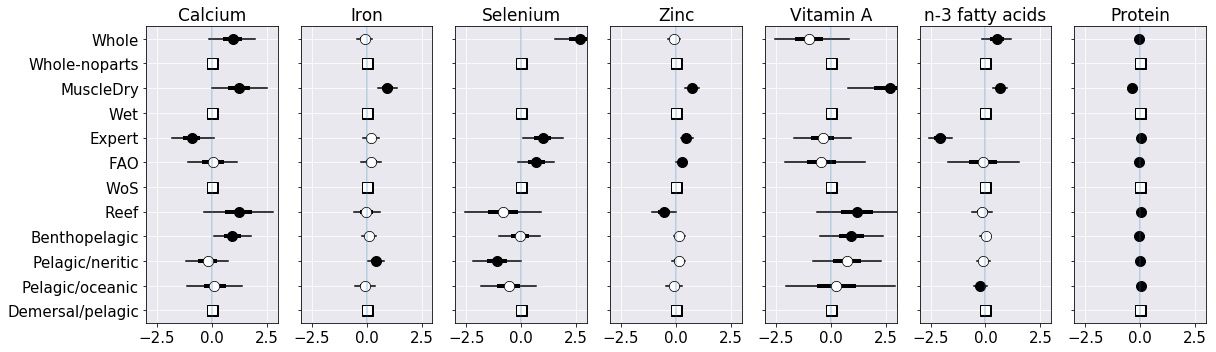

In [12]:
# Set up multipanel grid
fig = plt.figure(figsize=(17, 5),facecolor='white')
gs = mp.gridspec.GridSpec(1, 7)
ax = [fig.add_subplot(gs[0,i]) for i in range(7)]

# Asthetic controls
split3 = Snvar+.5
jit = 0.1
szero = (10,90)
ymajor_ticks = np.arange(0, Snvar)
#yminor_ticks = (split1,split2)
xmajor_ticks = np.arange(-3, 3)
xminor_ticks = np.arange(-3, 3, 0.1)

# Loop over nutrietns
for i in range(nnutrients):
    ax_ = ax[i]
    resx = Results[i]
    resx['DemersPelag']=0
    rescol = list(resx.columns)
    xlimx = []
    # Loop over variables
    for j in range(Snvar):
        yloc = j
        try:
            trace = resx[resx.columns[rescol.index(Svarord[j])]]
            mx = '.'
        except ValueError:
            pass
        else:
            if np.mean(trace)==0:
                mx = 's'
                ms = 8
            else:
                mx = '.'
                ms = 17
            x95 = np.percentile(trace,(2.5,97.5))
            xlimx += list(x95)
            ax_.plot(x95,(j,j),c='black')
            ax_.plot(np.percentile(trace,(25,75)),(j,j),c='black',linewidth=4)
            ax_.plot(np.median(trace),j, marker=mx, markersize=ms+3,c='black')
            if spanzero(np.percentile(trace,szero)):
                ax_.plot(np.median(trace), j, marker=mx, markersize=ms,c='white')
    ax_.set_title(Nutrients[i],fontsize=17)
    ax_.set_xlim(-3,3)
    ax_.tick_params(axis='both', which='major', labelsize=15)
    ax_.set_facecolor('#E8E8EE')
    ax_.set_yticks(ymajor_ticks) 
    #ax_.set_xticks(xmajor_ticks)
    #ax_.set_xticks(xminor_ticks, minor=True)
    #ax_.grid(which='minor', alpha=0.2)
    ax_.grid(color='white')
    ax_.axvline(x=0, linestyle="-",alpha=0.3)
    #ax_.set_xlim(min(xlimx),max(xlimx))
    ax_.set_ylim(-0.5,split3-1)
    if i==0:
        ax_.set_yticklabels(Svarnames)
    else:
        ax_.set_yticklabels('')

plt.tight_layout()
plt.savefig('Figure_ED2_reported.svg')


## Calculate total nutrient yeilds per country

In [13]:
# Total catch per country
mdata = pd.read_csv('SAU_Total_EEZ.csv')
# Predicted nutrients by country
pdata = pd.read_csv('SAU_nutrient_projections_by_EEZ_reported.csv')
# SAU key
kdata = pd.read_excel('SAUkey.xlsx')

In [14]:
# Make EEZs SAU compatible
mdata.EEZ = kdata.SAUname.values[match(list(mdata.EEZ.values),list(kdata.EEZ.values))]
pdata.EEZ = kdata.SAUname.values[match(list(pdata.EEZ.values),list(kdata.EEZ.values))]

In [15]:
tmp = mdata.groupby(['EEZ']).sum().reported_annual/1000
pdata.set_index('EEZ', inplace=True)

In [16]:
pdata

,Protein_mu,Zinc_mu,Iron_mu,Calcium_mu,Omega3_mu,Vitamin_A_mu,Selenium_mu
EEZ,,,,,,,
Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267
Algeria,19.858117,1.368307,2.447297,149.157704,0.331769,32.877411,11.780553
American Samoa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Andaman & Nicobar Isl. (India),20.966075,1.234781,2.518956,41.426187,0.043227,12.719542,6.689949
Angola,19.307061,1.814234,2.469531,120.355042,0.213628,36.352289,7.188646
Anguilla (UK),19.695900,1.019666,1.993239,289.921896,0.035241,33.027219,2.152313
Antigua & Barbuda,19.596605,0.671592,1.776465,315.079356,0.001904,32.470926,1.255084
Argentina,19.786774,0.630181,0.571552,76.911885,0.744974,8.846186,29.557614
Aruba (Netherlands),21.005253,0.967241,2.356435,79.333944,0.094618,10.389000,6.623393


In [17]:
pdata = pd.concat([pdata,tmp],axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [18]:
pdata.columns = ['Protein','Zinc','Iron','Calcium','Omega3','Vitamin_A','Selenium','Catch']
pdata.head()

,Protein,Zinc,Iron,Calcium,Omega3,Vitamin_A,Selenium,Catch
Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267,3.454033
Algeria,19.858117,1.368307,2.447297,149.157704,0.331769,32.877411,11.780553,210.295259
American Samoa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.015412
Andaman & Nicobar Isl. (India),20.966075,1.234781,2.518956,41.426187,0.043227,12.719542,6.689949,70.338089
Angola,19.307061,1.814234,2.469531,120.355042,0.213628,36.352289,7.188646,379.092330


In [19]:

# So multiply by 10,000*1000 to convert to kilo-tonnes
fx = 10000*1000
#Units per kg
ug = 1000000000
mg = 1000000
g = 1000


pdata['Protein_y'] = (pdata['Protein']*fx*pdata['Catch'])/g
pdata['Calcium_y'] = (pdata['Calcium']*fx*pdata['Catch'])/mg
pdata['Iron_y'] = (pdata['Iron']*fx*pdata['Catch'])/mg
pdata['Zinc_y'] = (pdata['Zinc']*fx*pdata['Catch'])/mg
pdata['Omega3_y'] = (pdata['Omega3']*fx*pdata['Catch'])/g
pdata['Vitamin_A_y'] = (pdata['Vitamin_A']*fx*pdata['Catch'])/ug
pdata['Selenium_y'] = (pdata['Selenium']*fx*pdata['Catch'])/ug


In [20]:
(11.861441*fx*3.454033)/ug

0.40969808641552996

In [21]:
pdata.head()

,Protein,Zinc,Iron,Calcium,Omega3,Vitamin_A,Selenium,Catch,Protein_y,Calcium_y,Iron_y,Zinc_y,Omega3_y,Vitamin_A_y,Selenium_y
Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267,3.454033,6.989957e+05,4664.174952,68.288819,34.173375,12248.485779,0.926675,0.405098
Algeria,19.858117,1.368307,2.447297,149.157704,0.331769,32.877411,11.780553,210.295259,4.176068e+07,313671.579800,5146.549848,2877.484757,697695.493079,69.139637,24.773944
American Samoa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.015412,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Andaman & Nicobar Isl. (India),20.966075,1.234781,2.518956,41.426187,0.043227,12.719542,6.689949,70.338089,1.474714e+07,29138.388482,1771.785869,868.521190,30405.125319,8.946683,4.705582
Angola,19.307061,1.814234,2.469531,120.355042,0.213628,36.352289,7.188646,379.092330,7.319159e+07,456256.733081,9361.803920,6877.621554,809848.915997,137.808741,27.251605


# Figure 2

In [22]:
# Set upper limits for plotting
#ulims = [200,2,30,1.5,40,0.6,20,4000]
ulims = [250,3,30,2,50,0.6,22,4000]
# Set nutrient colours
cmlist = ['Reds', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'BuPu', 'RdPu']

# Aesthetics
def dcmax(x_,maxval):
    x_[x_>maxval] = maxval
    x = (x_-min(x_))/max(x_-min(x_))
    qlabels = np.round(np.percentile(x_,(.001,25,50,75,100)))
    return qlabels, x

In [23]:
# Sea around us polygon list
SAU = gp.GeoDataFrame.from_file('SAUEEZ_July2015.shp')
SAU.head()

,OBJECTID,EEZID,Name,Area_km2,BigMap_ID,Shape_Leng,Shape_Area,geometry
0,1,8,Albania,11104.517696,79,10.795162,1.186330,(POLYGON ((20.01002706600008 39.69120017600005...
1,2,12,Algeria,128841.900956,76,33.642817,13.077158,"POLYGON ((6.455250727000021 38.57212410500006,..."
2,3,16,American Samoa,404366.885662,164,29.825196,33.828782,"POLYGON ((-168.489166657 -11.04444465799997, -..."
3,4,24,Angola,490692.420449,73,49.007145,40.753717,(POLYGON ((12.36291108600005 -6.05293336899995...
4,5,28,Antigua & Barbuda,107937.028680,165,17.456021,9.247550,POLYGON ((-58.37216855399998 18.53182036900006...


In [24]:
pd.DataFrame({'SAUname':SAU.Name.values}).to_csv('SAUkey_tmp.csv')

In [25]:
# Set index for data
CmuSau = pdata.index.values
pdata['Name'] = CmuSau

In [26]:
# Check all the names match
CmuSau[match(list(CmuSau),list(SAU.Name.values))==None]

array([], dtype=object)

In [27]:
# Check geospatial projection for Sea Around Us
SAU.crs

{'init': 'epsg:4326'}

In [28]:
# Slice yield dataframe for plotting
new_areas_c = pdata[['Name','Protein','Zinc','Iron','Calcium','Omega3','Vitamin_A','Selenium','Catch']]
# Create concentration dataframe for plotting
new_areas_y = pdata[['Name','Protein_y','Zinc_y','Iron_y','Calcium_y','Omega3_y','Vitamin_A_y','Selenium_y','Catch']]

In [29]:
new_areas_y.head()

,Name,Protein_y,Zinc_y,Iron_y,Calcium_y,Omega3_y,Vitamin_A_y,Selenium_y,Catch
Albania,Albania,6.989957e+05,34.173375,68.288819,4664.174952,12248.485779,0.926675,0.405098,3.454033
Algeria,Algeria,4.176068e+07,2877.484757,5146.549848,313671.579800,697695.493079,69.139637,24.773944,210.295259
American Samoa,American Samoa,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.015412
Andaman & Nicobar Isl. (India),Andaman & Nicobar Isl. (India),1.474714e+07,868.521190,1771.785869,29138.388482,30405.125319,8.946683,4.705582,70.338089
Angola,Angola,7.319159e+07,6877.621554,9361.803920,456256.733081,809848.915997,137.808741,27.251605,379.092330


In [30]:
new_areas_c.head()

,Name,Protein,Zinc,Iron,Calcium,Omega3,Vitamin_A,Selenium,Catch
Albania,Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267,3.454033
Algeria,Algeria,19.858117,1.368307,2.447297,149.157704,0.331769,32.877411,11.780553,210.295259
American Samoa,American Samoa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.015412
Andaman & Nicobar Isl. (India),Andaman & Nicobar Isl. (India),20.966075,1.234781,2.518956,41.426187,0.043227,12.719542,6.689949,70.338089
Angola,Angola,19.307061,1.814234,2.469531,120.355042,0.213628,36.352289,7.188646,379.092330


In [31]:
# Add data-shading info to SAU shapes
SAUEEZ_y = SAU.merge(new_areas_y, on=('Name'))
SAUEEZ_c = SAU.merge(new_areas_c, on=('Name'))
nsaueez = len(SAUEEZ_c.geometry)

In [32]:
SAUEEZ_c.head()

,OBJECTID,EEZID,Name,Area_km2,BigMap_ID,Shape_Leng,Shape_Area,geometry,Protein,Zinc,Iron,Calcium,Omega3,Vitamin_A,Selenium,Catch
0,1,8,Albania,11104.517696,79,10.795162,1.186330,(POLYGON ((20.01002706600008 39.69120017600005...,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267,3.454033
1,2,12,Algeria,128841.900956,76,33.642817,13.077158,"POLYGON ((6.455250727000021 38.57212410500006,...",19.858117,1.368307,2.447297,149.157704,0.331769,32.877411,11.780553,210.295259
2,3,16,American Samoa,404366.885662,164,29.825196,33.828782,"POLYGON ((-168.489166657 -11.04444465799997, -...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.015412
3,4,24,Angola,490692.420449,73,49.007145,40.753717,(POLYGON ((12.36291108600005 -6.05293336899995...,19.307061,1.814234,2.469531,120.355042,0.213628,36.352289,7.188646,379.092330
4,5,28,Antigua & Barbuda,107937.028680,165,17.456021,9.247550,POLYGON ((-58.37216855399998 18.53182036900006...,19.596605,0.671592,1.776465,315.079356,0.001904,32.470926,1.255084,3.598066


In [33]:
# Aesthetics
def dcmax(x_,maxval):
    #x_[x_==0] = min(x_[x_!=0])
    x_[x_>maxval] = maxval
    x = (x_-min(x_))/max(x_-min(x_))
    qlabels = np.round(np.percentile(x_,(.001,25,50,75,100)))
    return qlabels, x

# Aesthetics
def dcmax2(x_):
    x = (x_-min(x_))/max(x_-min(x_))
    qlabels = np.round(np.percentile(x_,(.001,25,50,75,100)))
    return qlabels, x

In [34]:
def colourbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [35]:
# Map aesthetics
water = '#dde5e8'
#e1e6e8
earth = '#efefe7'
lin = 'black'

# Linewidths
lwdx = 0.3


# Fonts
xfa = 1.3
tsize = 14*xfa
lsize = 14*xfa
asize = 14*xfa

cmlist = {'Protein':'BuPu', 'Zinc':'Blues', 'Iron':'Greys', 'Calcium':'Reds', 'Omega3':'Oranges', 'Vitamin_A':'Greens', 'Selenium':'Purples', 'Catch':'RdPu'}

# Re-iterate nutrient labels
Nlab = {'Protein':'Protein','Zinc':'Zinc','Iron':'Iron','Calcium':'Calcium','Omega3':'Omega 3','Vitamin_A':'Vitamin A','Selenium':'Selenium','Catch':'Catch','Protein_y':'Protein','Zinc_y':'Zinc','Iron_y':'Iron','Calcium_y':'Calcium','Omega3_y':'Omega 3','Vitamin_A_y':'Vitamin A','Selenium_y':'Selenium'}

# Concentration labels
ulxc = {'Protein':'g/100g', 'Zinc':'mg/100g', 'Iron':'mg/100g', 'Calcium':'mg/100g', 'Omega3':'g/100g', 'Vitamin_A':'μg/100g', 'Selenium':'μg/100g', 'Catch':'kt/yr'}

# Yield labels
ulxy = ['log(kg)']*len(ulxc)

## Nutrient Map concentrations - Reported

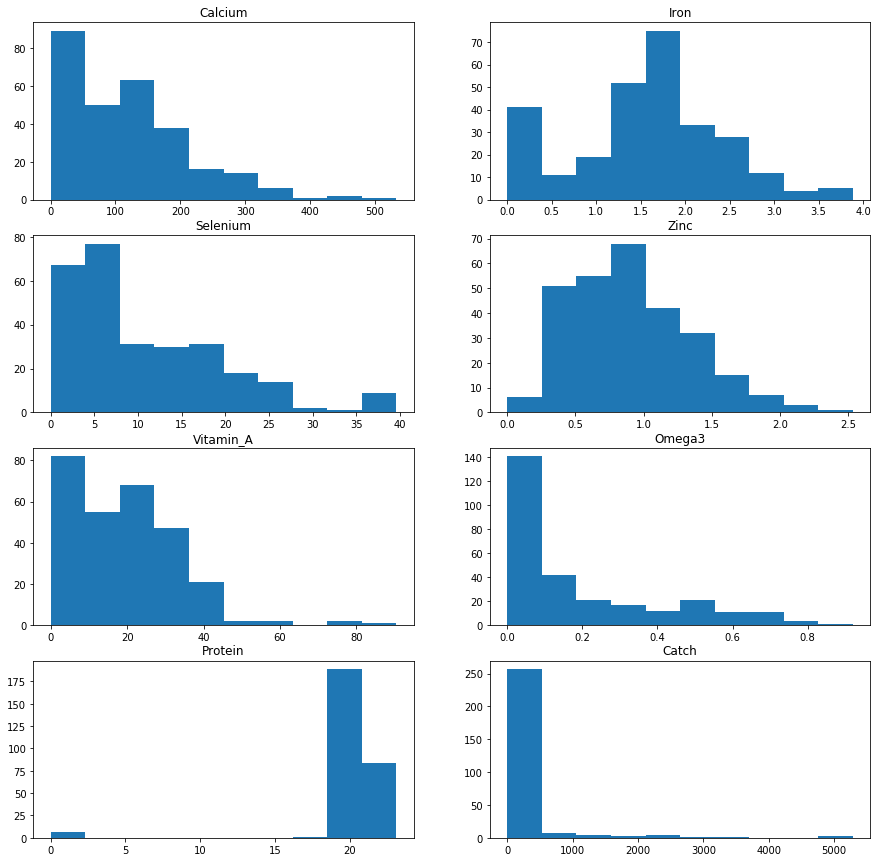

In [36]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

nutx = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin_A', 'Omega3', 'Protein','Catch']

for i in range(len(nutx)):
    ax_[i].hist(pdata[nutx[i]])
    ax_[i].set_title(nutx[i])

In [37]:
# Set plotting limits based on reported+unreported data
ulims = {'Protein':22,'Zinc':2,'Iron':3,'Calcium':300,'Omega3':0.7,'Vitamin_A':60,'Selenium':30,'Catch':4000}
mtitles = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin_A', 'Omega3', 'Protein','Catch']

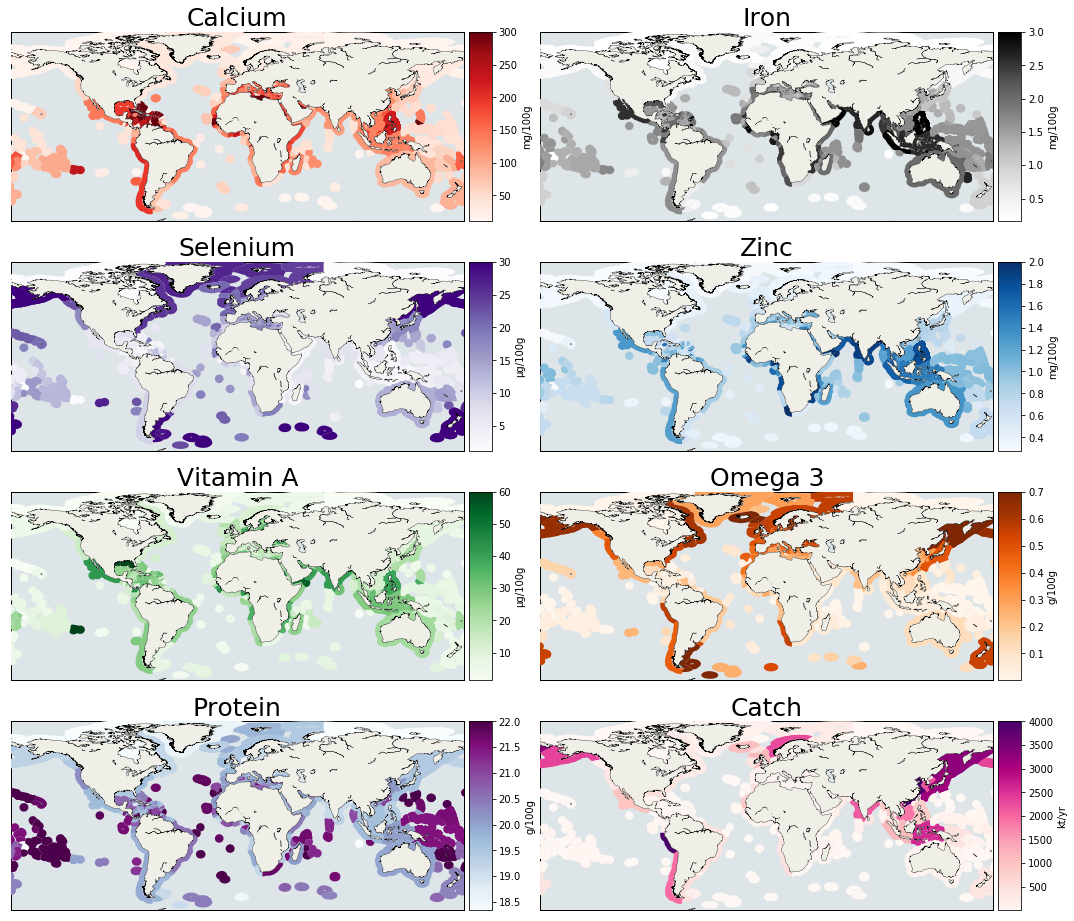

In [64]:
#"""
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for n in range(nnutrients+1):
#for n in range(1):
    # Grab plot frame
    ax = ax_[n]
    # Loop over nutrients
    nut = mtitles[n]
    x = SAUEEZ_c[nut].values
    # Deal with dumb zeros
    x[x==0] = min(x[x!=0])
    # Colormap for nutrient
    cm = mp.cm.get_cmap(cmlist[nut])
    qlabels, x_ = dcmax(x,ulims[nut])
    cmx = cm(x_)
    
    # Initialize map
    mm = Basemap(resolution='l', projection='cyl', ellps='WGS84',llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=85,lon_0=0, area_thresh=10000., ax=ax)
    bound = mm.drawmapboundary(fill_color=water,zorder=0)
    coast = mm.drawcoastlines(linewidth=lwdx,color=lin)
    continents = mm.fillcontinents(color=earth,zorder=1)

    # Iterate over EEZs
    patches = []
    COLx = []
    Xx = []
    for i in range(nsaueez):
    #for i in range(50):
        # Grab polygon
        poly = SAUEEZ_c.geometry[i]
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(mm, poly)
            patches.append(PolygonPatch(mpoly))
            COLx.append(cmx[i])
            Xx.append(x[i])
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(mm, poly)
                patches.append(PolygonPatch(mpoly))
                COLx.append(cmx[i])
                Xx.append(x[i])
        else:
            print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
            
    p = PatchCollection(patches, facecolor=cmx, linewidth=lwdx)
    ax.add_collection(p)
    ax.set_title(Nlab[nut],fontsize=tsize)
    ax.tick_params(labelsize=asize)
    p.set(array=np.array(Xx), cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(p, ax=ax, label=ulxc[nut], cax=cax)

# Sort out bounding box to avoid clipping
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=-13, rect=[0.01, 0.01, 1.01, 1.01])
plt.savefig('Figure_2_reported.jpg',dpi=300)

#"""

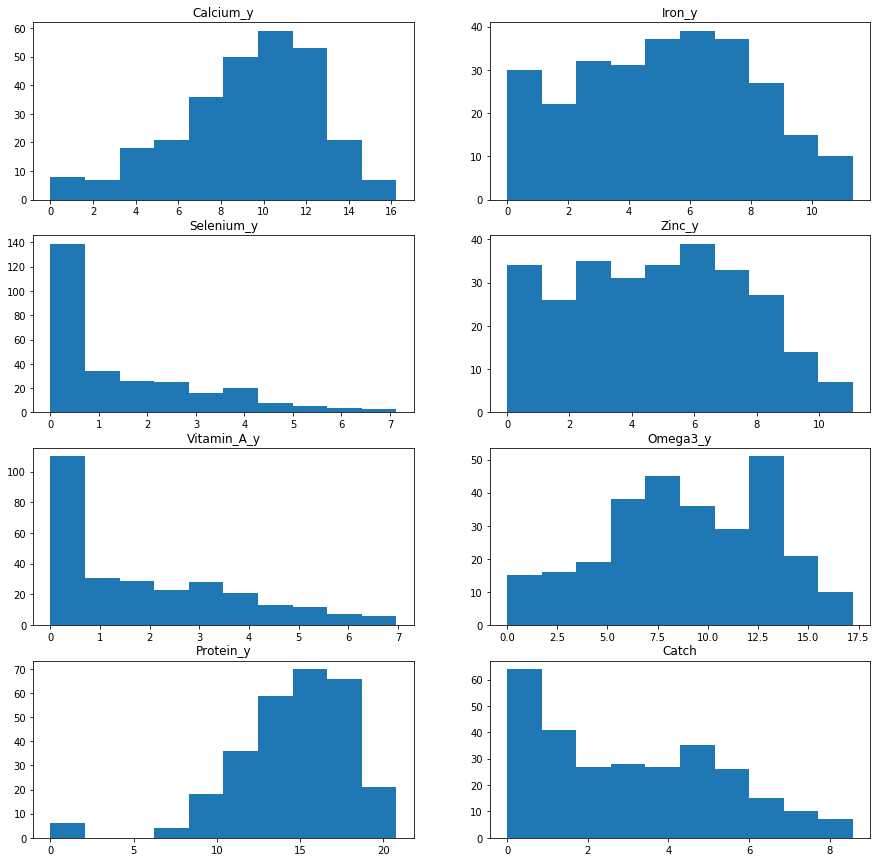

In [39]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

nutx = ['Calcium_y', 'Iron_y', 'Selenium_y', 'Zinc_y', 'Vitamin_A_y', 'Omega3_y', 'Protein_y','Catch']
for i in range(len(nutx)):
    ax_[i].hist(np.log(pdata[nutx[i]]+1))
    ax_[i].set_title(nutx[i])

## Nutrient Map Yield - Reported

In [40]:
ulims_y = {'Protein_y':20,'Zinc_y':10,'Iron_y':10,'Calcium_y':16,'Omega3_y':16,'Vitamin_A_y':6.5,'Selenium_y':6.5,'Catch':9}
ytitles = ['Calcium_y', 'Iron_y', 'Selenium_y', 'Zinc_y', 'Vitamin_A_y', 'Omega3_y', 'Protein_y','Catch']

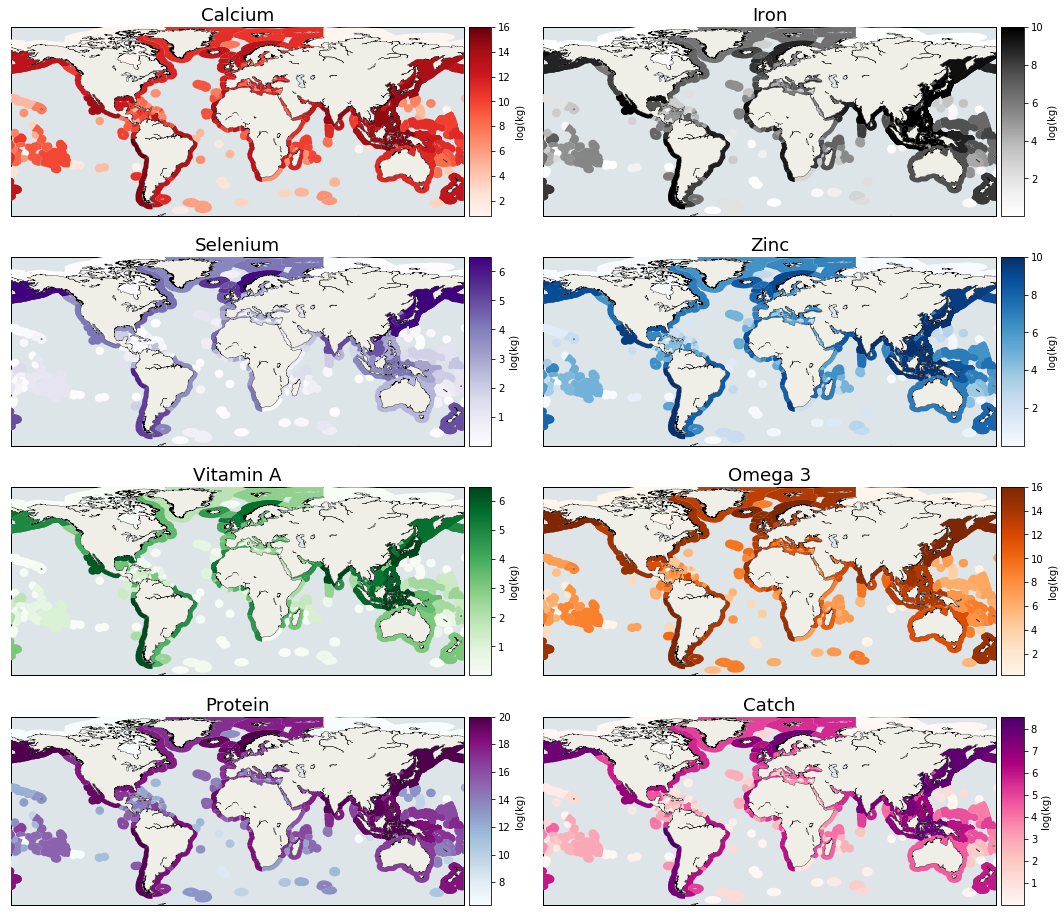

In [41]:
#"""
# Plots of yield
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for n in range(nnutrients+1):
    # Grab plot frame
    ax = ax_[n]
    # Loop over nutrients
    nut = ytitles[n]
    x = np.log(SAUEEZ_y[nut].values+1)
    # Deal with dumb zeros
    x[x==0] = min(x[x!=0])
    # Colormap for nutrient
    if nut=='Catch':
        cm = mp.cm.get_cmap(cmlist[nut])
    else:
        cm = mp.cm.get_cmap(cmlist[nut[:-2]])
    qlabels,x_ = dcmax(x,ulims_y[nut])
    cmx = cm(x_)
    # Initialize map
    mm = Basemap(resolution='l', projection='cyl', ellps='WGS84',llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=85,lon_0=0, area_thresh=10000., ax=ax)
    bound = mm.drawmapboundary(fill_color=water,zorder=0)
    coast = mm.drawcoastlines(linewidth=lwdx,color=lin)
    continents = mm.fillcontinents(color=earth,zorder=1)

    # Iterate over EEZs
    patches = []
    COLx = []
    Xx = []
    for i in range(nsaueez):
    #for i in range(80):
        # Grab polygon
        poly = SAUEEZ_y.geometry[i]
        colx = cmx[i]
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(mm, poly)
            patches.append(PolygonPatch(mpoly))
            COLx.append(cmx[i])
            Xx.append(x[i])
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(mm, poly)
                patches.append(PolygonPatch(mpoly))
                COLx.append(cmx[i])
                Xx.append(x[i])
        else:
            print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
    p = PatchCollection(patches, facecolor=cmx, linewidth=lwdx)
    ax.add_collection(p)
    ax.set_title(Nlab[nut],fontsize=tsize)
    ax.tick_params(labelsize=asize)
    p.set(array=np.array(Xx),cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(p, ax=ax, label=ulxy[n], cax=cax)

# Sort out bounding box to avoid clipping
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=-13, rect=[0.01, 0.01, 1.01, 1.01])
plt.savefig('Figure_ED4_reported.jpg',dpi=300)

#"""

## SAU nutrients Reported vs Reported+Unreported

In [42]:
# Predicted nutrients by country - reported and unreported
pdata_u = pd.read_csv('SAU_nutrient_projections_by_EEZ_reported_unreported.csv')
pdata_u.EEZ = kdata.SAUname.values[match(list(pdata_u.EEZ.values),list(kdata.EEZ.values))]

In [43]:
tmp = mdata.groupby(['EEZ']).sum().reported_unreported_annual/1000
pdata_u.set_index('EEZ', inplace=True)

In [44]:
pdata_u = pd.concat([pdata_u,tmp],axis=1)
pdata_u.columns = ['Protein','Zinc','Iron','Calcium','Omega3','Vitamin_A','Selenium','Catch']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [45]:
pdata_u.columns

Index(['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega3', 'Vitamin_A', 'Selenium',
       'Catch'],
      dtype='object')

In [46]:
pdata_u.head()

,Protein,Zinc,Iron,Calcium,Omega3,Vitamin_A,Selenium,Catch
Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267,3.454033
Algeria,20.015903,1.163892,2.148592,160.562508,0.307972,27.750090,12.432795,352.859505
American Samoa,22.296031,0.720899,1.365986,63.001625,0.038725,5.493692,15.737362,7.118400
Andaman & Nicobar Isl. (India),20.782494,1.243658,2.529065,75.303924,0.041174,16.340851,5.948449,95.836096
Angola,19.364734,1.774958,2.425857,130.886521,0.218339,35.719790,7.460908,605.697698


In [47]:

# So multiply by 10,000
fx = 10000*1000
#Units per kg
ug = 1000000000
mg = 1000000
g = 1000


pdata_u['Protein_y'] = (pdata_u['Protein']*fx*pdata_u['Catch'])/g
pdata_u['Calcium_y'] = (pdata_u['Calcium']*fx*pdata_u['Catch'])/mg
pdata_u['Iron_y'] = (pdata_u['Iron']*fx*pdata_u['Catch'])/mg
pdata_u['Zinc_y'] = (pdata_u['Zinc']*fx*pdata_u['Catch'])/mg
pdata_u['Omega3_y'] = (pdata_u['Omega3']*fx*pdata_u['Catch'])/g
pdata_u['Vitamin_A_y'] = (pdata_u['Vitamin_A']*fx*pdata_u['Catch'])/ug
pdata_u['Selenium_y'] = (pdata_u['Selenium']*fx*pdata_u['Catch'])/ug



In [48]:
# Set index for data
CmuSau_u = pdata_u.index.values
pdata_u['Name'] = CmuSau_u

In [49]:
# Slice yield dataframe for plotting
new_areas_c_u = pdata_u[['Name','Protein','Zinc','Iron','Calcium','Omega3','Vitamin_A','Selenium','Catch']]
# Create concentration dataframe for plotting
new_areas_y_u = pdata_u[['Name','Protein_y','Zinc_y','Iron_y','Calcium_y','Omega3_y','Vitamin_A_y','Selenium_y','Catch']]

In [50]:
# Add data-shading info to SAU shapes
SAUEEZ_y_u = SAU.merge(new_areas_y_u, on=('Name'))
SAUEEZ_c_u = SAU.merge(new_areas_c_u, on=('Name'))
nsaueez = len(SAUEEZ_c_u.geometry)

## Nutrient Map concentrations - Reported+Unreported

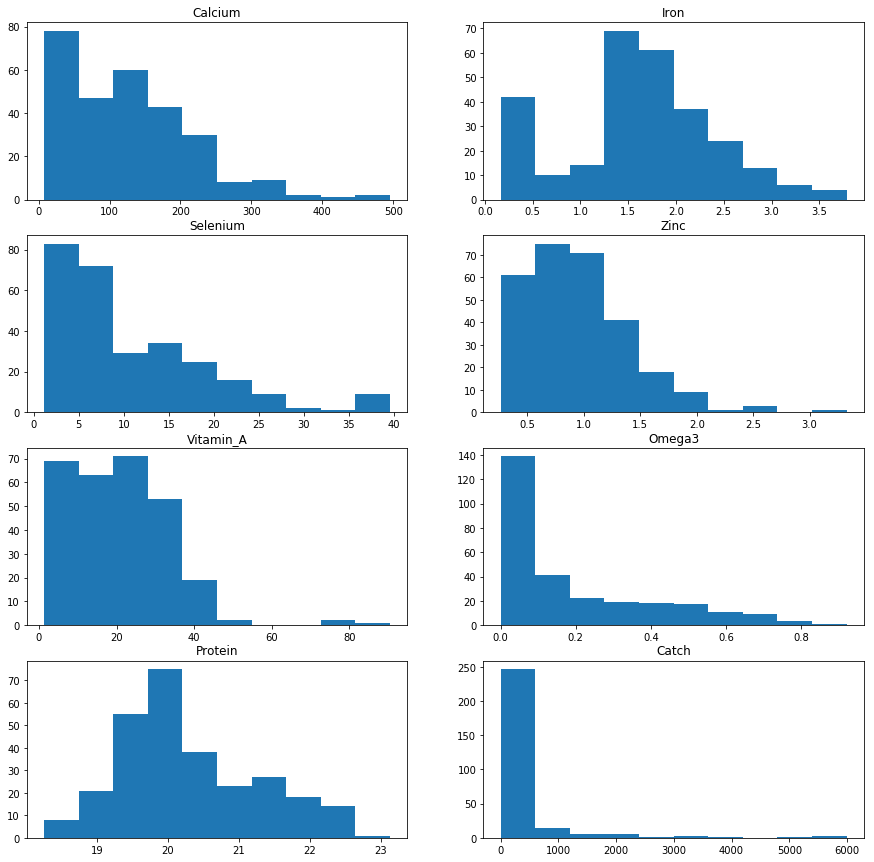

In [51]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]


nutx = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin_A', 'Omega3', 'Protein','Catch']
for i in range(len(nutx)):
    ax_[i].hist(pdata_u[nutx[i]])
    ax_[i].set_title(nutx[i])

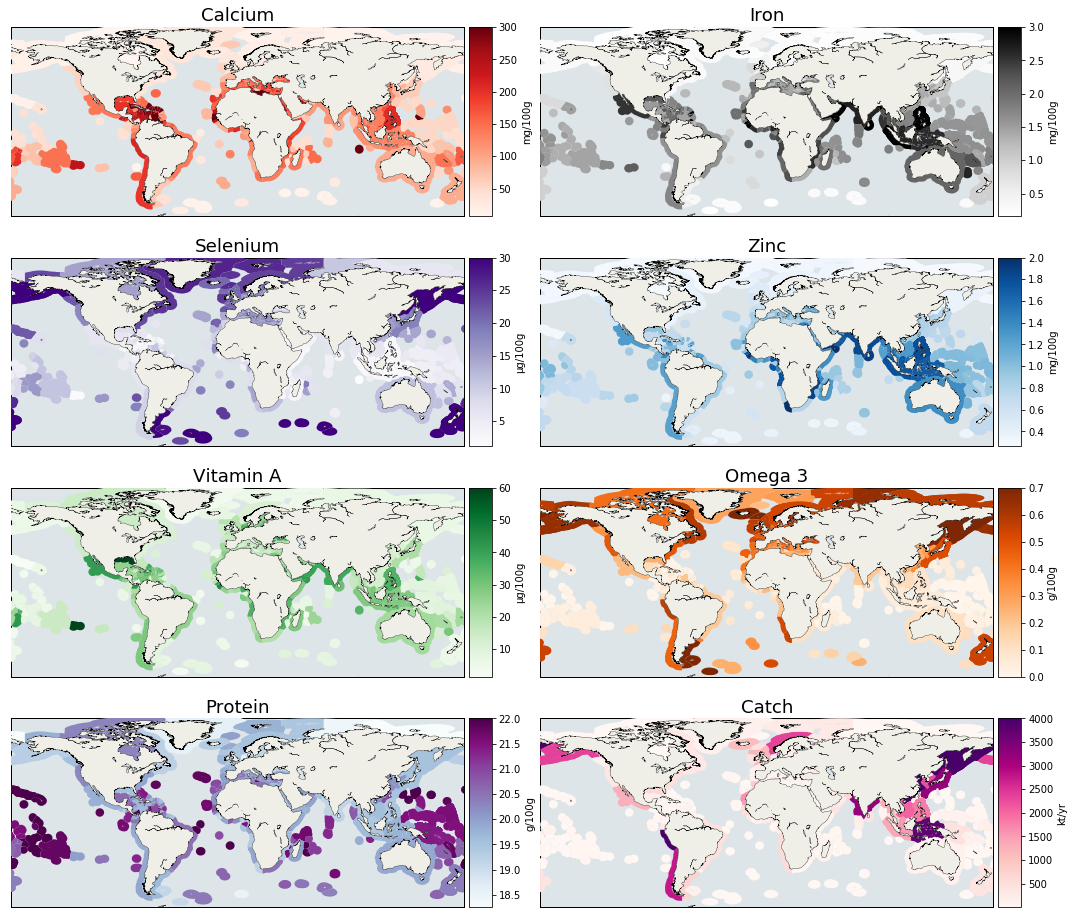

In [52]:
#"""
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for n in range(nnutrients+1):
    # Grab plot frame
    ax = ax_[n]
    # Loop over nutrients
    nut = mtitles[n]
    x = SAUEEZ_c_u[nut].values
    # Colormap for nutrient
    cm = mp.cm.get_cmap(cmlist[nut])
    qlabels,x_ = dcmax(x,ulims[nut])
    cmx = cm(x_)
    # Initialize map
    mm = Basemap(resolution='l', projection='cyl', ellps='WGS84',llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=85,lon_0=0, area_thresh=10000., ax=ax)
    bound = mm.drawmapboundary(fill_color=water,zorder=0)
    coast = mm.drawcoastlines(linewidth=lwdx,color=lin)
    continents = mm.fillcontinents(color=earth,zorder=1)

    # Iterate over EEZs
    patches = []
    COLx = []
    Xx = []
    for i in range(nsaueez):
    #for i in range(30):
        # Grab polygon
        poly = SAUEEZ_c.geometry[i]
        colx = cmx[i]
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(mm, poly)
            patches.append(PolygonPatch(mpoly))
            COLx.append(cmx[i])
            Xx.append(x[i])
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(mm, poly)
                patches.append(PolygonPatch(mpoly))
                COLx.append(cmx[i])
                Xx.append(x[i])
        else:
            print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
    p = PatchCollection(patches, facecolor=cmx, linewidth=lwdx)
    ax.add_collection(p)
    ax.set_title(Nlab[nut],fontsize=tsize)
    ax.tick_params(labelsize=asize)
    p.set(array=np.array(Xx),cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(p, ax=ax, label=ulxc[nut], cax=cax)

# Sort out bounding box to avoid clipping
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=-13, rect=[0.01, 0.01, 1.01, 1.01])
plt.savefig('Figure_2.jpg',dpi=300)


## Nutrient Map Yield - Reported+Unreported


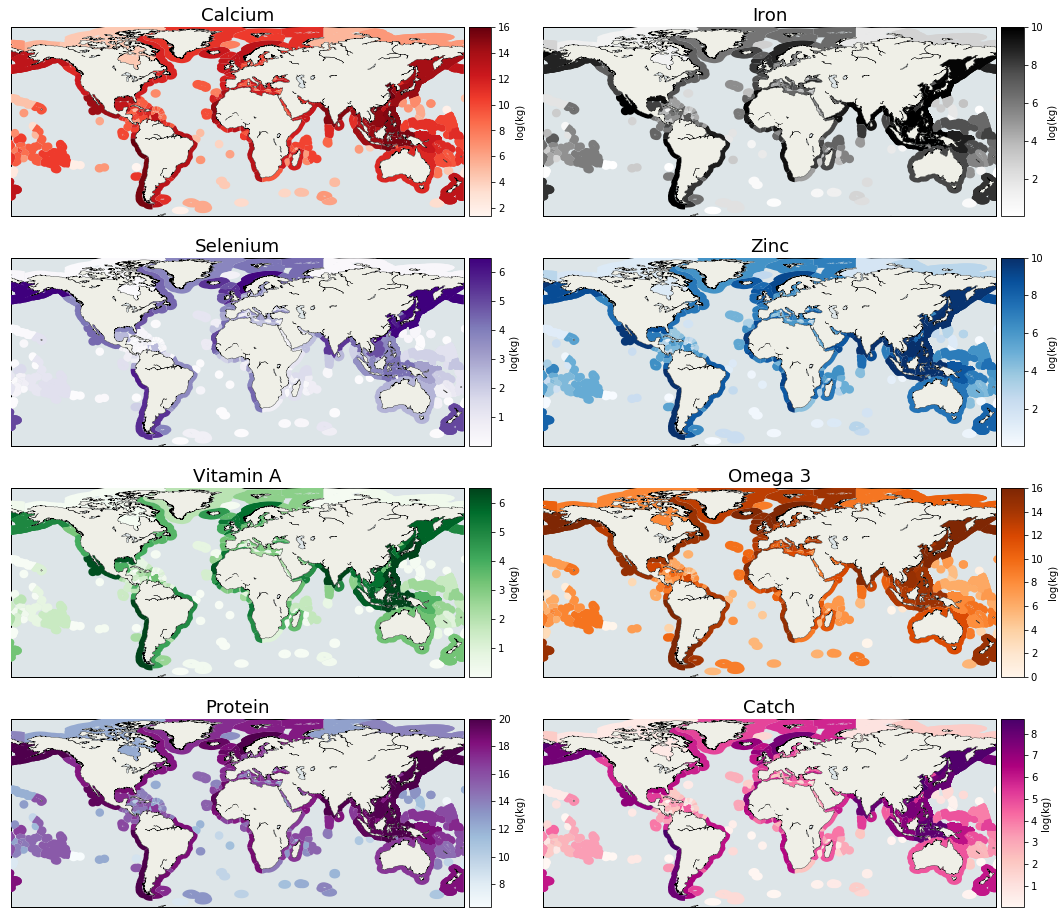

In [53]:
#"""
# Plots of yield
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for n in range(nnutrients+1):
    # Grab plot frame
    ax = ax_[n]
    # Loop over nutrients
    nut = ytitles[n]
    x = np.log(SAUEEZ_y_u[nut].values+1)
    # Colormap for nutrient
    if nut=='Catch':
        cm = mp.cm.get_cmap(cmlist[nut])
    else:
        cm = mp.cm.get_cmap(cmlist[nut[:-2]])
    qlabels,x_ = dcmax(x,ulims_y[nut])
    cmx = cm(x_)
    # Initialize map
    mm = Basemap(resolution='l', projection='cyl', ellps='WGS84',llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=85,lon_0=0, area_thresh=10000., ax=ax)
    bound = mm.drawmapboundary(fill_color=water,zorder=0)
    coast = mm.drawcoastlines(linewidth=lwdx,color=lin)
    continents = mm.fillcontinents(color=earth,zorder=1)

    # Iterate over EEZs
    patches = []
    COLx = []
    Xx = []
    for i in range(nsaueez):
    #for i in range(30):
        # Grab polygon
        poly = SAUEEZ_y.geometry[i]
        colx = cmx[i]
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(mm, poly)
            patches.append(PolygonPatch(mpoly))
            COLx.append(cmx[i])
            Xx.append(x[i])
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(mm, poly)
                patches.append(PolygonPatch(mpoly))
                COLx.append(cmx[i])
                Xx.append(x[i])
        else:
            print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
    p = PatchCollection(patches, facecolor=cmx, linewidth=lwdx)
    ax.add_collection(p)
    ax.set_title(Nlab[nut],fontsize=tsize)
    ax.tick_params(labelsize=asize)
    p.set(array=np.array(Xx),cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(p, ax=ax, label=ulxy[n], cax=cax)

# Sort out bounding box to avoid clipping
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=-13, rect=[0.01, 0.01, 1.01, 1.01])
plt.savefig('Figure_ED4.jpg',dpi=300)

#"""

# Correlation between reported only and reported+unreported data

In [54]:
poops = ['Calcium_y', 'Iron_y', 'Selenium_y', 'Zinc_y', 'Vitamin_A_y', 'Omega3_y', 'Protein_y','Catch']

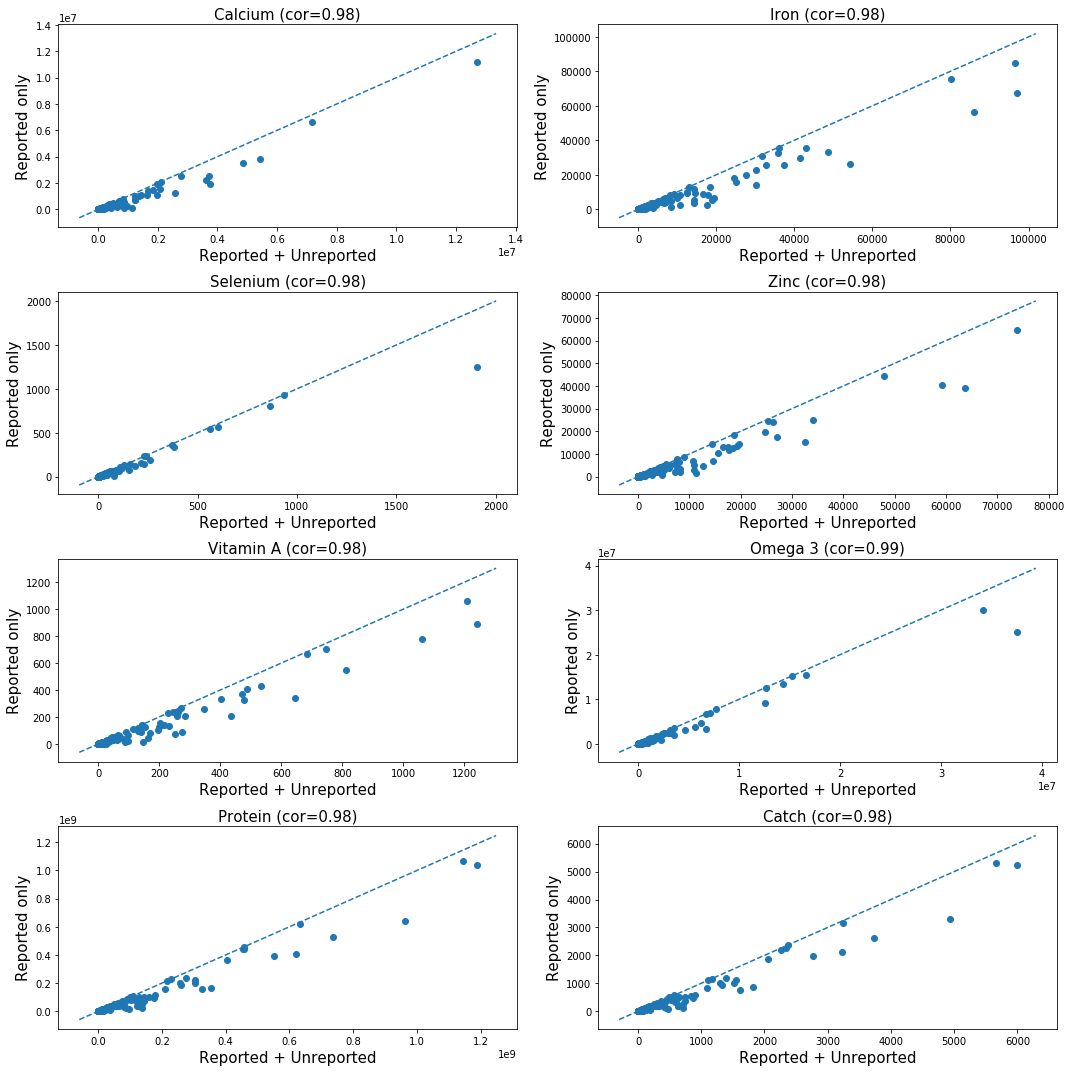

In [55]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for i in range(nnutrients+1):
    x = pdata_u[poops[i]]
    y = pdata[poops[i]]
    ax_[i].scatter(x,y)
    abline(0,1,ax=ax_[i])
    xcor = str(np.round(np.corrcoef(x,y)[0,1],2))
    ax_[i].set_title(Nlab[poops[i]]+' (cor='+xcor+')',fontsize=15)
    ax_[i].set_xlabel('Reported + Unreported',fontsize=15)
    ax_[i].set_ylabel('Reported only',fontsize=15)
plt.tight_layout()
plt.savefig('Figure_ED5.jpg',dpi=300)

In [56]:
doops = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin_A', 'Omega3', 'Protein','Catch']

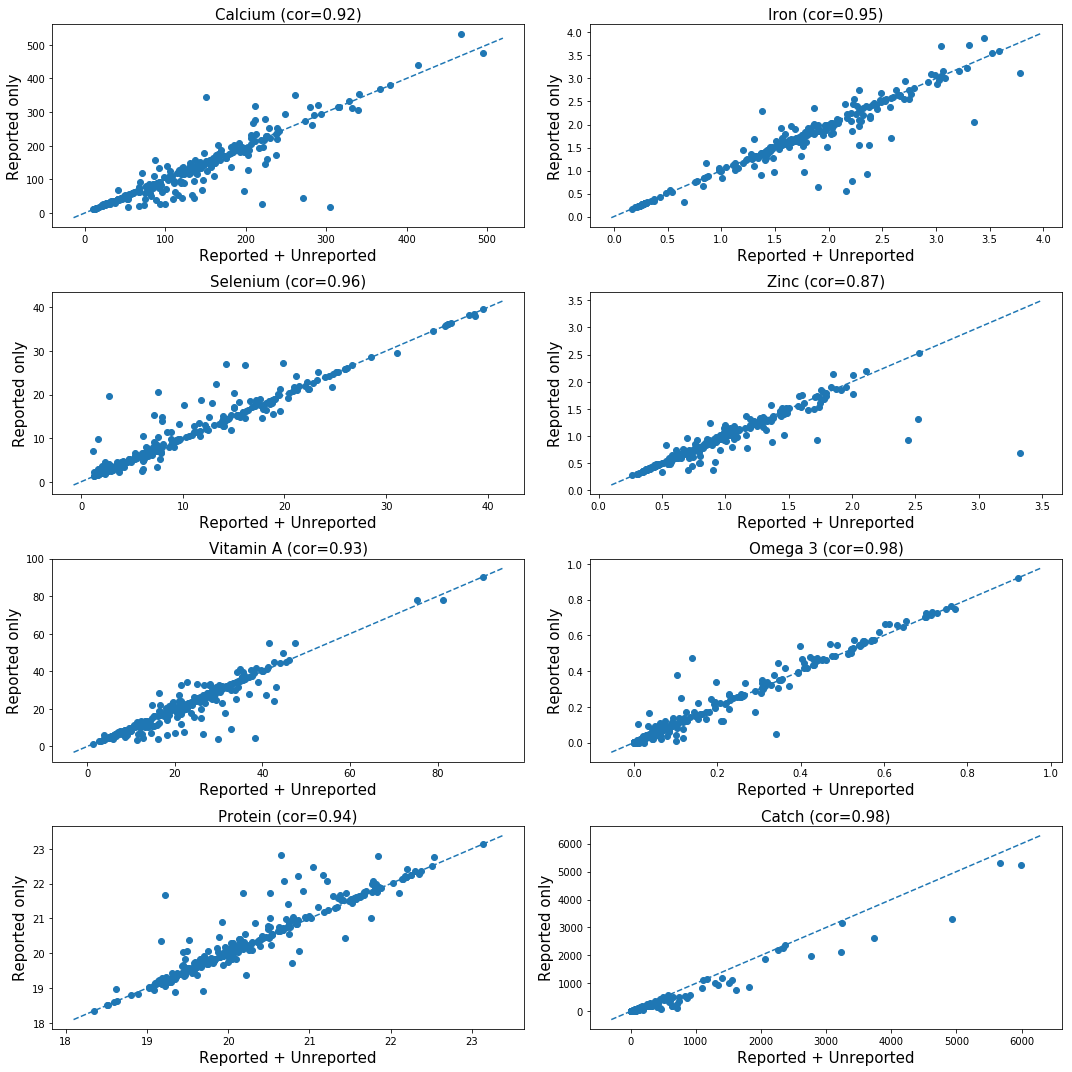

In [57]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for i in range(nnutrients+1):
    x = pdata_u[doops[i]]
    y = pdata[doops[i]]
    x = x[y!=0]
    y = y[y!=0]
    ax_[i].scatter(x,y)
    abline(0,1,ax=ax_[i])
    xcor = str(np.round(np.corrcoef(x,y)[0,1],2))
    ax_[i].set_title(Nlab[doops[i]]+' (cor='+xcor+')',fontsize=15)
    ax_[i].set_xlabel('Reported + Unreported',fontsize=15)
    ax_[i].set_ylabel('Reported only',fontsize=15)
plt.tight_layout()
plt.savefig('Figure_ED5b.jpg',dpi=300)

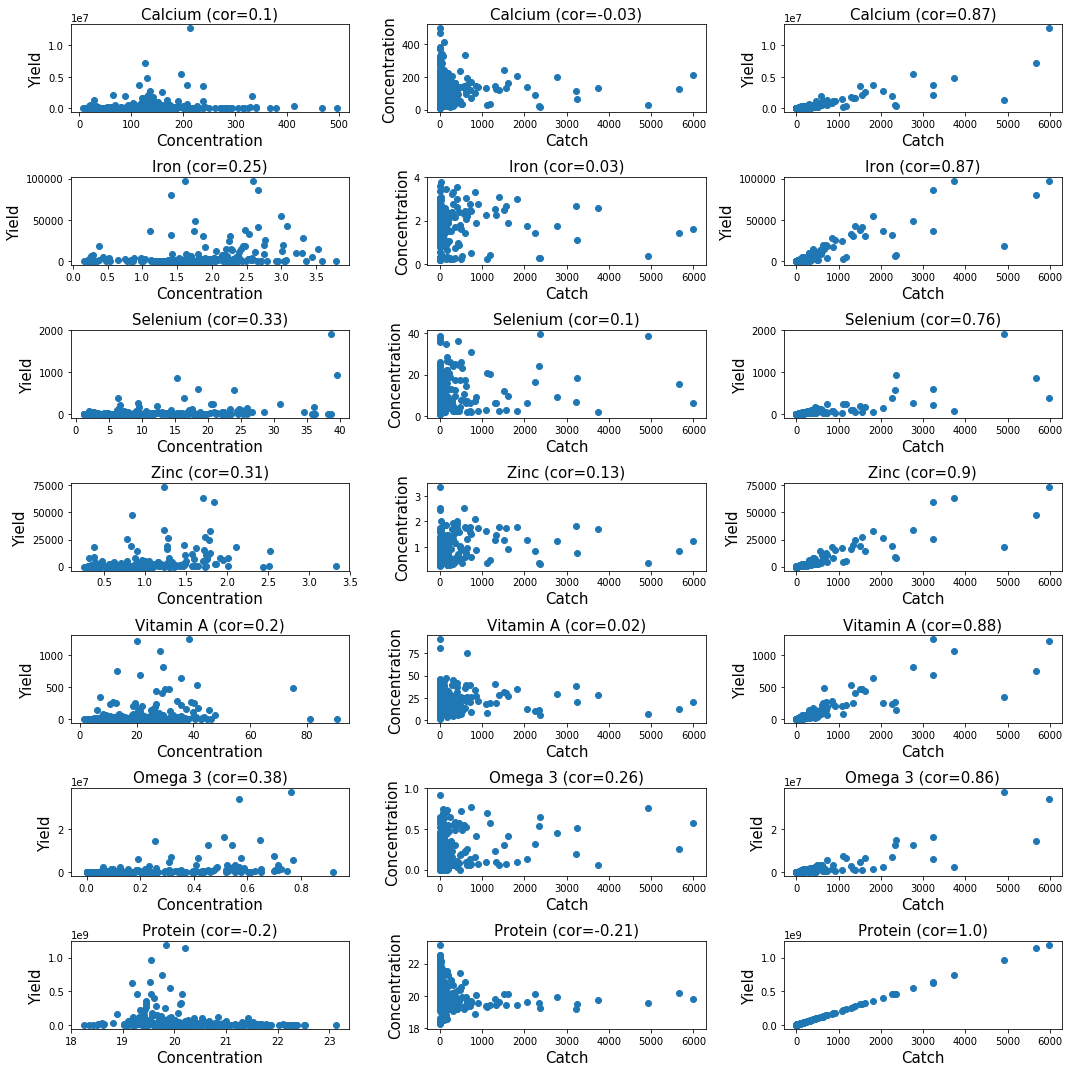

In [58]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(nnutrients, 3)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(nnutrients) for j in range(3)])

ix = 0
for i in range(nnutrients):
    # Yields v concentrations
    x = pdata_u[doops[i]]
    y = pdata_u[poops[i]]
    x = x[y!=0]
    y = y[y!=0]
    ax_[ix].scatter(x,y)
    #abline(0,1,ax=ax_[ix])
    xcor = str(np.round(np.corrcoef(x,y)[0,1],2))
    ax_[ix].set_title(Nlab[doops[i]]+' (cor='+xcor+')',fontsize=15)
    ax_[ix].set_xlabel('Concentration',fontsize=15)
    ax_[ix].set_ylabel('Yield',fontsize=15)

    # Next panel
    ix += 1

    # Concentrations v catch
    x = pdata_u['Catch']
    y = pdata_u[doops[i]]
    x = x[y!=0]
    y = y[y!=0]
    ax_[ix].scatter(x,y)
    #abline(0,1,ax=ax_[ix])
    xcor = str(np.round(np.corrcoef(x,y)[0,1],2))
    ax_[ix].set_title(Nlab[doops[i]]+' (cor='+xcor+')',fontsize=15)
    ax_[ix].set_xlabel('Catch',fontsize=15)
    ax_[ix].set_ylabel('Concentration',fontsize=15)

    # Next panel
    ix += 1

    # Yield v catch
    x = pdata_u['Catch']
    y = pdata_u[poops[i]]
    x = x[y!=0]
    y = y[y!=0]
    ax_[ix].scatter(x,y)
    #abline(0,1,ax=ax_[ix])
    xcor = str(np.round(np.corrcoef(x,y)[0,1],2))
    ax_[ix].set_title(Nlab[doops[i]]+' (cor='+xcor+')',fontsize=15)
    ax_[ix].set_xlabel('Catch',fontsize=15)
    ax_[ix].set_ylabel('Yield',fontsize=15)

    # Next panel
    ix += 1
        
plt.tight_layout()
plt.savefig('Figure_ED6.jpg',dpi=300)

In [59]:
# Export datframes
pdata.to_csv('National_EEZ_results_restricted.csv')
pdata_u.to_csv('National_EEZ_results.csv')